<a href="https://colab.research.google.com/github/chless/arxiv-course-rl/blob/2022-UNIST/05_1_Double_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Double Q-learning

In [ ]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print ("plt version:[%s]"%(matplotlib.__version__))
print ("gym version:[%s]"%(gym.__version__))

plt version:[3.2.2]
gym version:[0.17.3]


### Q Learning
Have one Q function $Q$

---

Given $(S_t, A_t, R_{t+1}, S_{t+1})$

1. Find the best action in $S_{t+1}$

    $a^* = \underset{a}{\arg\max} Q_{old}(S_{t+1},a)$

2. Update Q function with $(S_t, A_t, R_{t+1}, S_{t+1}, a^*)$ with 1-step TD error

    $Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma Q_{old}(S_{t+1},a^*) - Q_{old}(S_{t}, A_{t}))$

3. Policy improvement

    Behavior policy: $\pi_b(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

    Target policy: $\pi(a|s) = \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [ ]:
class Q_learning():
    def __init__(self,n_state,n_action,alpha=0.5,epsilon=1.0,gamma=0.999):
        self.n_state = n_state
        self.n_action = n_action
        self.alpha_init = alpha
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        
        # Initial Q value
        self.Q = np.zeros([n_state,n_action])
        
    def update_Q(self,state,action,reward,state_prime,done):
        """
        Update value
        """
        Q_old = self.Q[state][action]
        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma*np.max(self.Q[state_prime])
        td_error = td_target - Q_old # TD error
        self.Q[state,action] = Q_old + self.alpha*td_error # update Q
        
    def update_epsilon(self,epsilon):
        self.epsilon = np.min([epsilon,1.0]) 
        
    def update_alpha(self,alpha):
        self.alpha = np.min([alpha,self.alpha_init]) 
        
    def get_action(self,state):
        """
        Get action
        """
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0,high=self.n_action)
        else:
            action = np.argmax(self.Q[state])
        return action 
    

### Double Q Learning
Have two Q functions $Q_A, Q_B$

---

Given $(S_t, A_t, R_{t+1}, S_{t+1})$

1. Randomly choose one Q function to update. Assume $Q_A$ is chosen.

2. Find the best action in $S_{t+1}$ w.r.t $Q_A$

    $a^* = \underset{a}{\arg\max} Q_A(S_{t+1},a)$

3. Update $Q_A$ function with $(S_t, A_t, R_{t+1}, S_{t+1}, a^*)$ with 1-step TD error, but make TD target with $Q_B$

    $Q_A(S_{t}, A_{t}) \leftarrow Q_A(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma Q_B(S_{t+1},a^*) - Q_A(S_{t}, A_{t}))$

3. Policy improvement

    Behavior policy: $\pi_b(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q_A(s,a')\right)$

    Target policy: $\pi(a|s) = \mathbf{1}\left(a = \max_{a'} Q_A(s,a')\right)$

In [ ]:
class Double_Q_learning():
    def __init__(self,n_state,n_action,alpha=0.5,epsilon=1.0,gamma=0.999):
        self.n_state = n_state
        self.n_action = n_action
        self.alpha_init = alpha
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        
        # Initialize Two Q tables
        self.Q_A = np.zeros([n_state,n_action])
        self.Q_B = np.zeros([n_state,n_action])
        
    def update_Q(self,state,action,reward,state_prime,done):
        """
        Update value
        """
        if np.random.uniform() < 0.5:
            Q_update = self.Q_A
            Q_target = self.Q_B
        else:
            Q_update = self.Q_B
            Q_target = self.Q_A

        action_prime = np.argmax(Q_update[state_prime])

        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * Q_target[state_prime][action_prime]

        Q_old = Q_update[state][action]
        td_error = td_target - Q_old # TD error
        Q_update[state,action] = Q_old + self.alpha * td_error # update Q
        
    def update_epsilon(self,epsilon):
        self.epsilon = np.min([epsilon,1.0]) 
        
    def update_alpha(self,alpha):
        self.alpha = np.min([alpha,self.alpha_init]) 
        
    def get_action(self,state):
        """
        Get action
        """
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0,high=self.n_action)
        else:
            action = np.argmax(self.Q_A[state])
        return action 


### Run Q learning on Cliff Walking

In [ ]:
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv

In [ ]:
env = CliffWalkingEnv()

In [ ]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [ ]:
# 4x12 grid = 48 states
print ("Number of states:", env.nS)
print ("Number of actions that an agent can take:", env.nA)
action_space = ["up", "right", "down", "left"]

Number of states: 48
Number of actions that an agent can take: 4


In [ ]:
print ("Current state", env.s)
print ("Transitions from current state:", env.P[env.s])

Current state 36
Transitions from current state: {0: [(1.0, 24, -1, False)], 1: [(1.0, 36, -100, False)], 2: [(1.0, 36, -1, False)], 3: [(1.0, 36, -1, False)]}


In [ ]:
for s in range(48):
    for a in range(4):
        if env.P[s][a][0][2] == -100:
            env.P[s][a][0] = (env.P[s][a][0][0], env.P[s][a][0][1], env.P[s][a][0][2], True)

In [ ]:
import random

def train(env, agent, n_episode):
    env.reset()
    is_terminal = False
    # Loop
    for e_idx in range(n_episode):
        state = env.reset() # reset environment, select initial 
        action = agent.get_action(state)
        done = False
        while not done:
            state_prime, reward, done, info = env.step(action) # step 
            action_prime = agent.get_action(state_prime) # Get next action
            agent.update_Q(state, action, reward, state_prime, done) # learns Q
            state = state_prime
            action = action_prime
        agent.update_epsilon(100/(e_idx+1)) # Decaying epsilon
    print ("Training Done.")

In [ ]:
q_learning = Q_learning(n_state=48,n_action=4,epsilon=1.0,alpha=0.1,gamma=0.999)
double_q_learning = Double_Q_learning(n_state=48,n_action=4,epsilon=1.0,alpha=0.1,gamma=0.999)

train(CliffWalkingEnv(), q_learning, 300)
train(CliffWalkingEnv(), double_q_learning, 300)

Training Done.
Training Done.


In [ ]:
from time import sleep

def run(env, agent):
    is_terminal = False
    state = env.reset()
    env.render()
    while not is_terminal:
        action = agent.get_action(state)
        print("Action taken:", action_space[action])
        next_state, reward, is_terminal, t_prob = env.step(action)
        print("Transition probability:", t_prob)
        print("Next state:", next_state)
        print("Reward recieved:", reward)
        print("Terminal state:", is_terminal)
        state = next_state
        env.render()
        sleep(1)

In [ ]:
run(env, agent_1)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action taken: left
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action taken: down
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action taken: left
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action taken: left
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -1
Te

In [ ]:
run(env, agent_2)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -100
Terminal state: True
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



## Particular example when Double Q-learning is effective

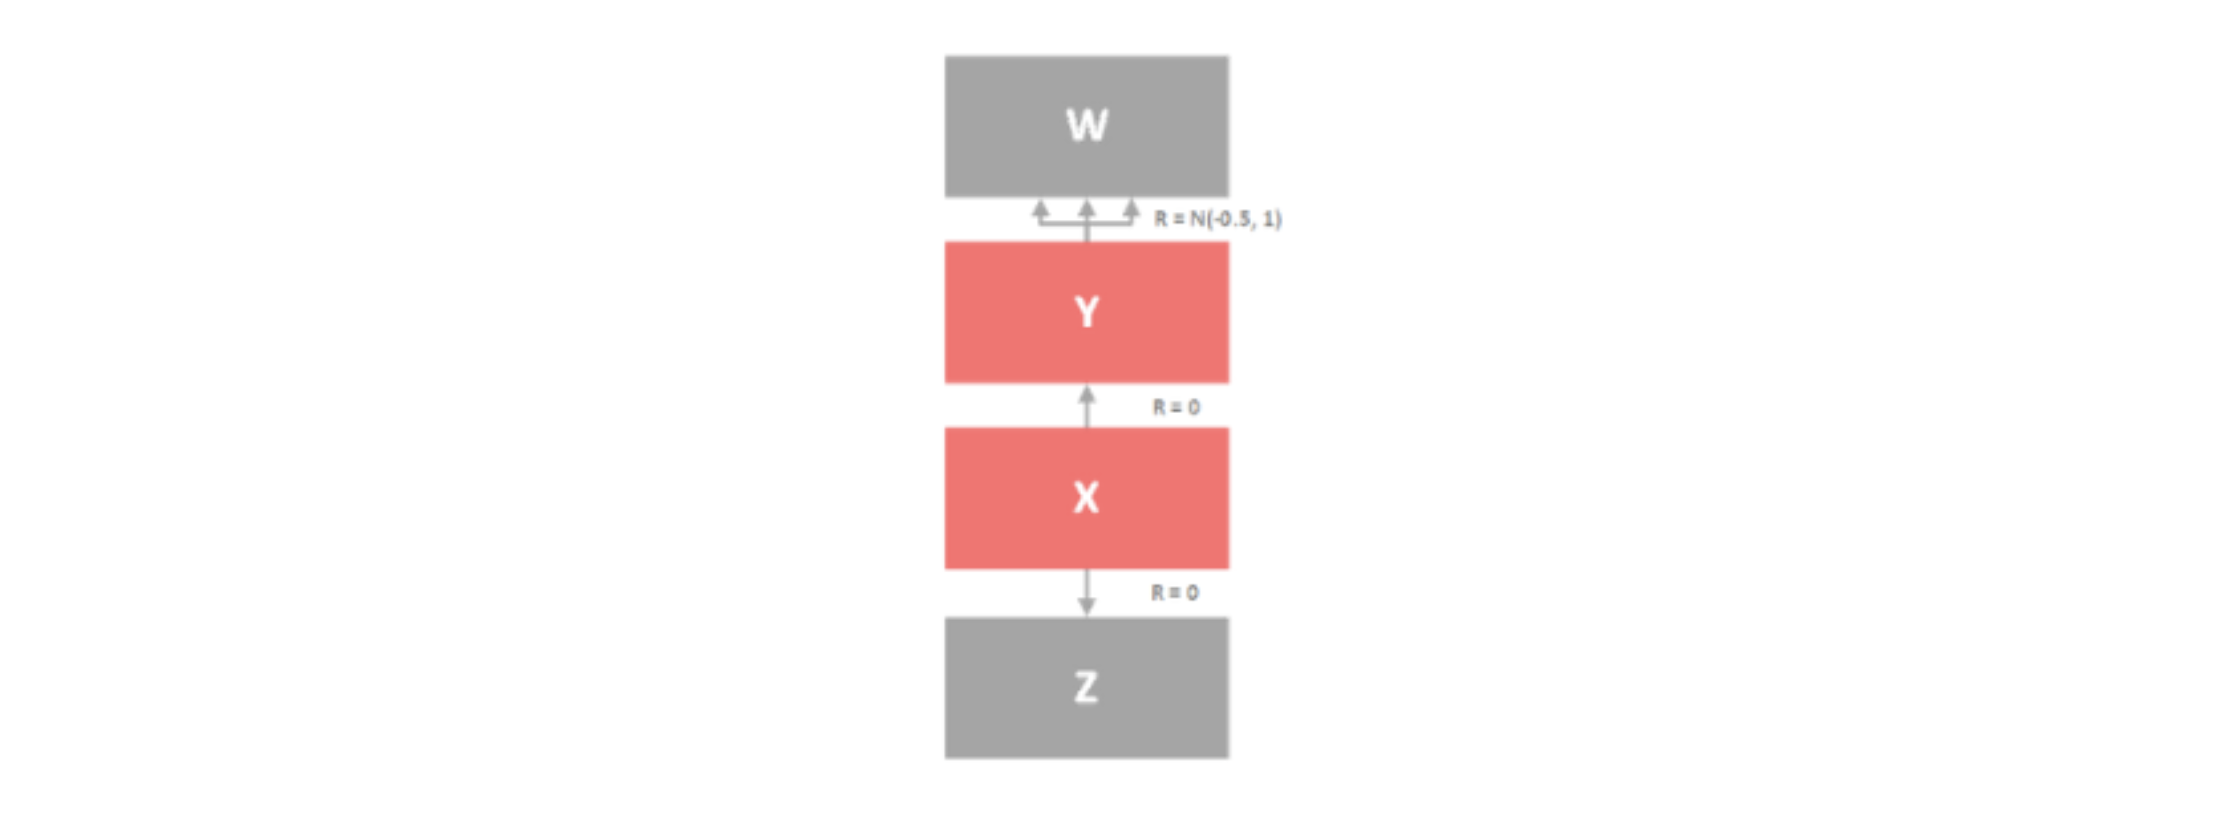

In [ ]:
class MDP():   
    def __init__(self, action_tree=9):
        # Actions
        self.down, self.up = 0, 1
        
        # States and posible actions
        self.state_actions = {
            0: [self.down, self.up], # X
            1: [i for i in range(action_tree)], # Y
            2: [self.down], # W
            3: [self.up] } # Z
        
        # Transitions
        self.transitions = {
            0: {self.down: 3,
                  self.up: 1},
            1: {a: 2 for a in range(action_tree)},
            2: {self.down: 'Done'},
            3: {self.up: 'Done'}
        }
        
        self.states_space = 4
        self.action_space = action_tree
        self.state = 0
    
    def _get_reward(self):
        return np.random.normal(-0.5, 1) if self.state == 2 else 0
    
    def _is_terminated_state(self):
        return True if self.state == 2 or self.state == 3 else False
    
    def reset(self):
        self.state = 0
        return self.state
    
    def step(self, action):
        self.state = self.transitions[self.state][action]
        return self.state, self._get_reward(), self._is_terminated_state(), None
    
    def available_actions(self, state):
        return self.state_actions[state]
    
    def random_action(self):
        return np.random.choice(self.available_actions(self.state))
    
mdp_enviroment = MDP()

In [ ]:
def mdp_q_learning(enviroment, num_of_tests = 100, num_of_episodes=300, epsilon=0.1, gamma=0.6, alpha=0.05):

    num_of_ups = np.zeros(num_of_episodes)
    
    for _ in range(num_of_tests):
        
        # Initialize Q-table
        Q = {state: np.zeros(9) for state in mdp_enviroment.state_actions.keys()}
        rewards = np.zeros(num_of_episodes)

        for episode in range(0, num_of_episodes):
            # Reset the enviroment
            state = enviroment.reset()

            # Initialize variables
            terminated = False

            while not terminated:
                # Pick action a....
                if np.random.rand() < epsilon:
                    action = enviroment.random_action()
                else:
                    available_actions = enviroment.available_actions(enviroment.state)
                    Q_available = Q[state][available_actions]
                    max_actions = np.where(np.max(Q_available) == Q_available)[0]
                    action = np.random.choice(max_actions)

                # ...and get r and s'    
                next_state, reward, terminated, _ = enviroment.step(action) 

                # 'up's from state 'X'
                if state == 0 and action == 1:
                    num_of_ups[episode] += 1

                # Update Q-Table
                max_value = np.max(Q[next_state])
                Q[state][action] += alpha * (reward + gamma * max_value - Q[state][action])
                state = next_state
                rewards[episode] += reward
            
    return rewards, Q, num_of_ups

In [ ]:
def mdp_double_q_learning(enviroment, num_of_tests = 10000, num_of_episodes=300, epsilon=0.1, gamma=0.6, alpha=0.05):

    num_of_ups = np.zeros(num_of_episodes)
    
    for _ in range(num_of_tests):
        
        # Initialize Q-table
        Q_A = {state: np.zeros(9) for state in mdp_enviroment.state_actions.keys()}
        Q_B = {state: np.zeros(9) for state in mdp_enviroment.state_actions.keys()}
        rewards = np.zeros(num_of_episodes)

        for episode in range(0, num_of_episodes):
            # Reset the enviroment
            state = enviroment.reset()

            # Initialize variables
            terminated = False

            while not terminated:
                if np.random.rand() < epsilon:
                    action = enviroment.random_action()
                else:
                    Q_available = Q_A[state][enviroment.available_actions(enviroment.state)] + Q_B[state][enviroment.available_actions(enviroment.state)]
                    max_actions = np.where(np.max(Q_available) == Q_available)[0]
                    action = np.random.choice(max_actions)

                next_state, reward, terminated, _ = enviroment.step(action) 

                # 'up's from state 'X'
                if state == 0 and action == 1:
                    num_of_ups[episode] += 1
               
                # Update(A) or Update (B)
                if np.random.rand() < 0.5:
                    # Update(A)
                    Q_A[state][action] += alpha * (reward + gamma * Q_B[next_state][np.argmax(Q_A[next_state])] - Q_A[state][action])
                else:
                    # Update(B)
                    Q_B[state][action] = alpha * (reward + gamma * Q_A[next_state][np.argmax(Q_B[next_state])] - Q_B[state][action])
                
                state = next_state
                rewards[episode] += reward
            
    return rewards, Q_A, Q_B, num_of_ups

In [ ]:
num_of_tests = 10000
rewards, _, num_of_ups = mdp_q_learning(MDP(), num_of_tests)
rewards_double, _, _, num_of_ups_double = mdp_double_q_learning(MDP(), num_of_tests)

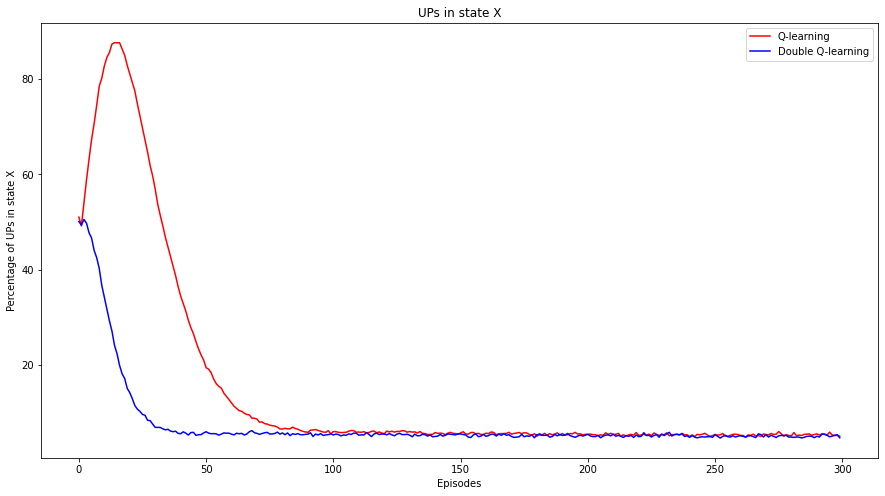

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(num_of_ups/num_of_tests*100, label='Q-learning', color='r')
plt.plot(num_of_ups_double/num_of_tests*100, label='Double Q-learning', color='b')
plt.legend()
plt.ylabel('Percentage of UPs in state X')
plt.xlabel('Episodes')
plt.title(r'UPs in state X')
plt.show()

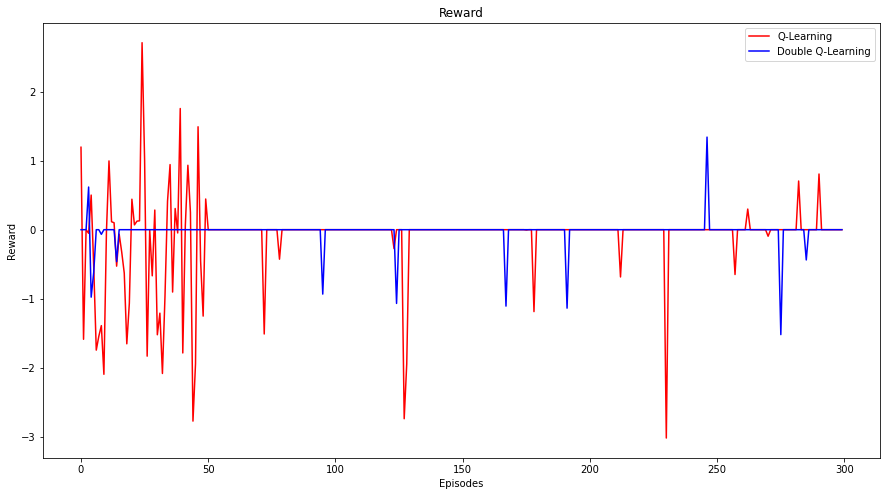

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(rewards, label='Q-Learning', color = "r")
plt.plot(rewards_double, label='Double Q-Learning', color = "b")
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.title(r'Reward')
plt.legend()
plt.show()